In [1]:
import numpy as np
from numpy import genfromtxt
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Read in the Dataset

Forest Fire Dataset: https://archive.ics.uci.edu/ml/datasets/forest+fires

Select temp, relative humidity, wind, and rain columns, and filter records with NaN values.


Features/Columns (In Order):

0. temp - temperature in Celsius degrees: 2.2 to 33.30
1. RH - relative humidity in %: 15.0 to 100
2. wind - wind speed in km/h: 0.40 to 9.40
3. rain - outside rain in mm/m2 : 0.0 to 6.4

In [2]:
forest_fires = genfromtxt('forestfires.csv', delimiter=',')
forest_fires

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 7.  ,  5.  ,   nan, ...,  6.7 ,  0.  ,  0.  ],
       [ 7.  ,  4.  ,   nan, ...,  0.9 ,  0.  ,  0.  ],
       ...,
       [ 7.  ,  4.  ,   nan, ...,  6.7 ,  0.  , 11.16],
       [ 1.  ,  4.  ,   nan, ...,  4.  ,  0.  ,  0.  ],
       [ 6.  ,  3.  ,   nan, ...,  4.5 ,  0.  ,  0.  ]])

In [3]:
forest_fires = np.delete(forest_fires, obj=[0, 1, 2, 3, 4, 5, 6, 7, 12], axis=1)

# Get rid of all rows with nan's
filtered = ~np.isnan(forest_fires)
good_indices = [index for index in range(
    0, filtered.shape[0]) if filtered[index, :].sum() == filtered.shape[1]]
forest_fires = forest_fires[good_indices, :]
forest_fires

array([[ 8.2, 51. ,  6.7,  0. ],
       [18. , 33. ,  0.9,  0. ],
       [14.6, 33. ,  1.3,  0. ],
       ...,
       [21.2, 70. ,  6.7,  0. ],
       [25.6, 42. ,  4. ,  0. ],
       [11.8, 31. ,  4.5,  0. ]])

## Gibbs Sampling Code


In [4]:
def gibbs_sampler(joint_cols, feature1, feature2, num_iterations=10000, B=1000):
    
    """
    Input Parameters:
    
    join_cols: (#, 2) matrix
    feature1: list of feature 1 values
    feature2: list of feature 2 values
    num_iterations: number of iterations to run gibbs sampling
    
    
    Output:
    
    sample_pairs: list of sampled (x, y) tuples
    samplesX: list of x values of sample pairs
    samplesY: list of y values of sample pairs
    
    """
    
    samplesX = []
    samplesY = []
    sample_pairs = []
    init_idx = np.random.randint(0, len(feature1))
    currX = feature1[init_idx]
    currY = feature2[init_idx]
    samplesX.append(currX)
    samplesY.append(currY)
    sample_pairs.append((currX, currY))

    sampleX = True
    for i in range(0, num_iterations-1):
        if sampleX:
            filtered = joint_cols[joint_cols[:,1]==currY]
            x_vals = filtered[:, 0]
            u, counts = np.unique(list(x_vals), return_counts=True)
            freq = counts/sum(counts)
            currX = np.random.choice(u, size=1, p=freq)[0]

        else:
            filtered = joint_cols[joint_cols[:, 0]==currX]
            y_vals = filtered[:, 1]
            u, counts = np.unique(list(y_vals), return_counts=True)
            freq = counts / sum(counts)
            currY = np.random.choice(u, size=1, p = freq)[0]

        samplesX.append(currX)
        samplesY.append(currY)
        sample_pairs.append((currX, currY))
        sampleX = not sampleX 
        
    return sample_pairs[B:], samplesX[B:], samplesY[B:]

In [5]:
def plot_samples(samplesX, samplesY, sample_pairs, xlabel, ylabel):
    plot_histogram(samplesX, samplesY)
    freq = {}
    for pair in sample_pairs: 
        if pair in freq.keys():
            freq[pair] += 1
        else:
            freq[pair] = 1

    Z = []
    for i in range(0,  len(sample_pairs)):
         Z.append(freq[sample_pairs[i]]/len(sample_pairs))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(xs=samplesX, ys=samplesY, zs=Z)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    
    

In [6]:
def plot_histogram(x, y):
    """
    reference: https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
    """
    # scatter points on the main axes
    fig = plt.figure()
    grid = plt.GridSpec(4, 4)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)
    main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

    x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
    x_hist.invert_yaxis()

    y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
    y_hist.invert_xaxis()
    
    

## Graphs Obtained from Gibbs Sampling


Temperature vs. Relative Humidity


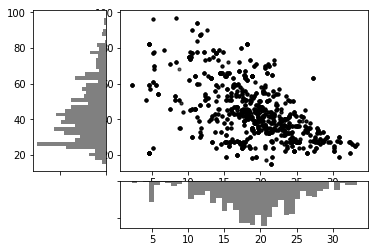

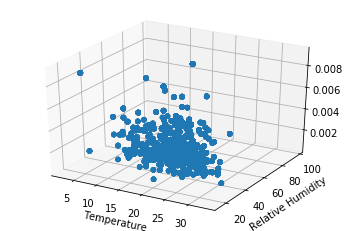



Temperature vs. Wind


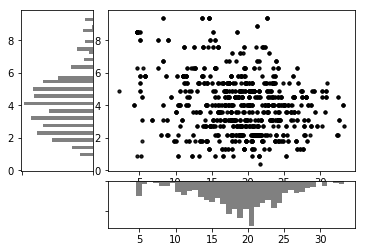

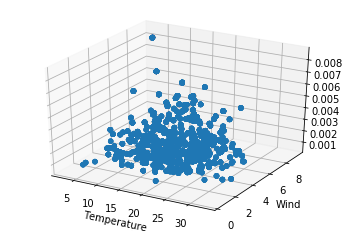



Temperature vs. Rain


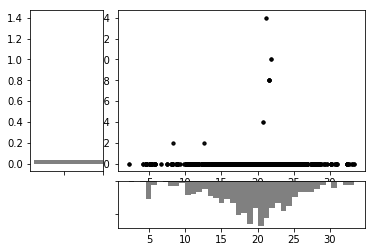

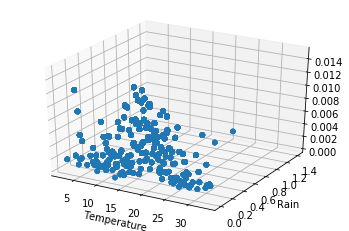



Relative Humidity vs. Wind


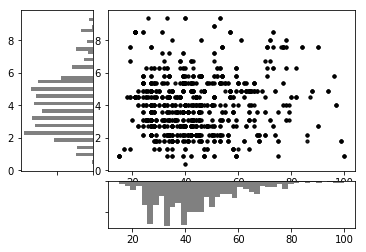

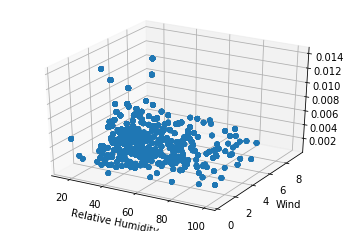



Relative Humidity vs. Rain


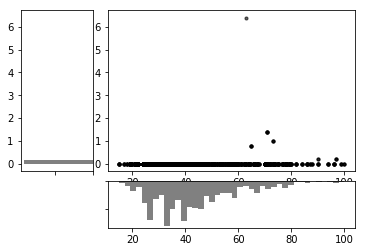

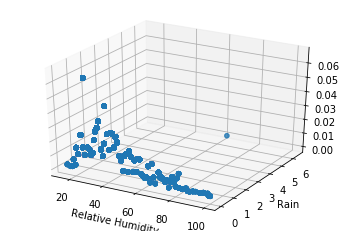



Wind vs. Rain


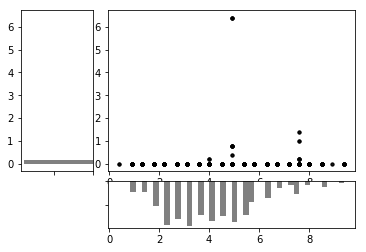

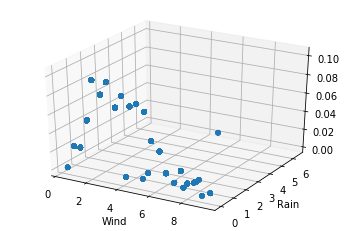

In [7]:
features = ["Temperature", "Relative Humidity", "Wind", "Rain"]
for i in range(0, 4):
    for j in range(0, 4):
        if i > j or i == j:
            continue
        feature1 = forest_fires[:, i]
        feature2 = forest_fires[:, j]
        joint_cols = np.zeros((forest_fires.shape[0], 2))
        joint_cols[:, 0] = feature1
        joint_cols[:, 1] = feature2
        sample_pairs, samplesX, samplesY = gibbs_sampler(
            joint_cols, list(feature1), list(feature2))
        print(features[i] + " vs. " + features[j])
        plot_samples(samplesX, samplesY, sample_pairs, features[i], features[j])
        print("\n")

All of the joint distributions look relatively normal. To make things more concrete, we can estimate the parameters of the multivariate normal distributions using MLE.

$\hat{\mu}= \dfrac{1}{n}\sum_{i=1}^{n}z_i$ 

$\hat{\Sigma} = \dfrac{1}{n}\sum_{i=1}^{n}(z_i - \hat{\mu})(z_i - \hat{\mu})^T$

where $n$ is the number of sample points and $z_i$ = $[x_i, y_i]^T$, with each sample point being $(x_i, y_i)$.


In [8]:
def MLE_mean(samplesX, samplesY):
    
    return np.array([sum(samplesX)/len(samplesX), sum(samplesY)/len(samplesY)])

def MLE_covariance(samplesX, samplesY, mu):
    
    data_matrix = np.zeros((len(samplesX), 2))
    for i in range(0, len(samplesX)):
        xi = samplesX[i]
        yi = samplesY[i]
        data_matrix[i, 0] = xi - mu[0]
        data_matrix[i, 1] = yi - mu[1]
    
    covariance = (np.dot(data_matrix.T, data_matrix) / len(samplesX)).round()
    
    # If the covariance matrix is not PD, add small epsilon to diagonals
    if np.all(np.linalg.eigvals(covariance) > 0) == False: 
        minimum_eig = min(np.linalg.eigvals(covariance))
        lambda_val = abs(minimum_eig) + 0.5
        covariance = covariance + (np.eye(2, 2) * lambda_val)
    
    return covariance


def gaussian_pdf(samplesX, samplesY, mu, covariance):
    data_matrix = np.zeros((len(samplesX), 2))
    data_matrix[:, 0] = samplesX
    data_matrix[:, 1] = samplesY
    
    return multivariate_normal.pdf(data_matrix, mean=mu, cov=covariance)

        

Compute the MLE estimates of the mean and covariance for each joint distribution, and compare the shapes of the estimated and sample distributions. 

In [9]:
def plot_samples_compare(samplesX, samplesY, pdf, sample_pairs, xlabel, ylabel):

    freq = {}
    for pair in sample_pairs: 
        if pair in freq.keys():
            freq[pair] += 1
        else:
            freq[pair] = 1

    Z = []
    for i in range(0,  len(sample_pairs)):
         Z.append(freq[sample_pairs[i]]/len(sample_pairs))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(xs=samplesX, ys=samplesY, zs=Z)
    ax.scatter(xs=samplesX, ys=samplesY, zs=pdf)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Temperature vs. Relative Humidity: 
Normal([18.93418889 43.81688889] , 
[[ 34. -47.]
 [-47. 252.]])

Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


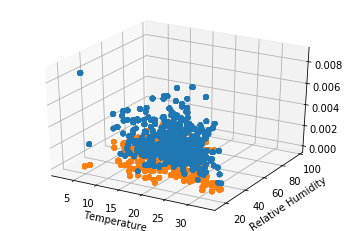

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


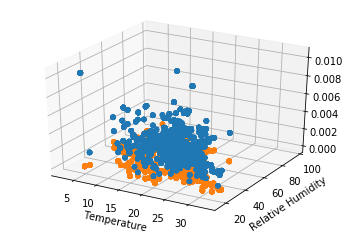

Temperature vs. Wind: 
Normal([18.74497778  4.03246667] , 
[[34. -3.]
 [-3.  3.]])

Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


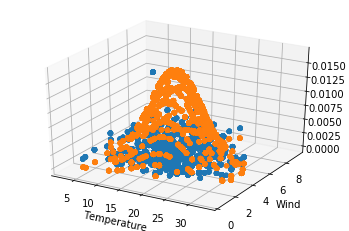

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


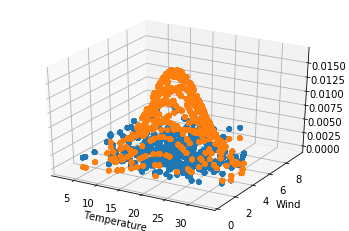

Temperature vs. Rain: 
Normal([1.88961333e+01 7.20000000e-03] , 
[[34.5  0. ]
 [ 0.   0.5]])

Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


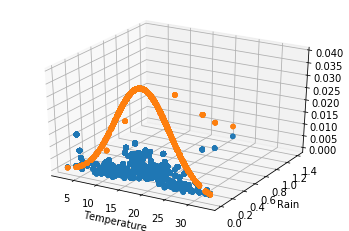

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


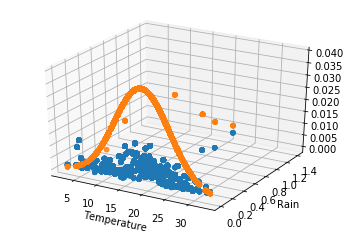

Relative Humidity vs. Wind: 
Normal([44.26344444  3.99333333] , 
[[276.   2.]
 [  2.   3.]])

Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


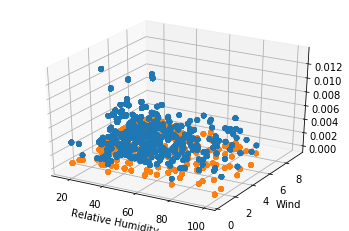

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


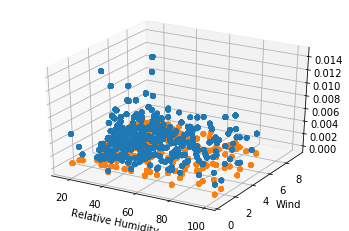

Relative Humidity vs. Rain: 
Normal([4.44091111e+01 1.28000000e-02] , 
[[254.5   0. ]
 [  0.    0.5]])

Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


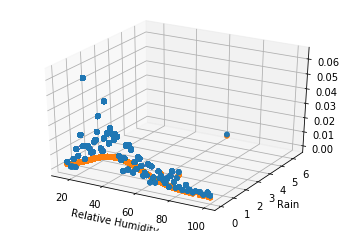

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


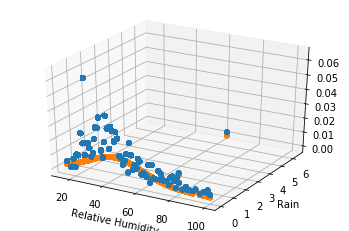

Wind vs. Rain: 
Normal([4.01516667 0.02577778] , 
[[3.5 0. ]
 [0.  0.5]])

Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


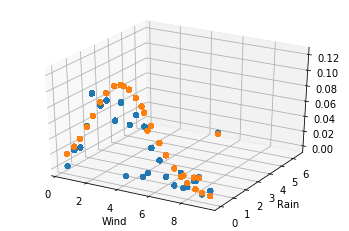

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


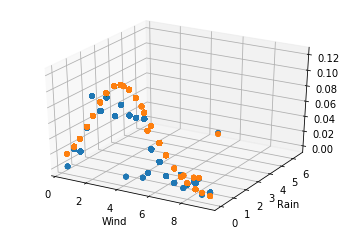

In [10]:
features = ["Temperature", "Relative Humidity", "Wind", "Rain"] 

for i in range(0, 4):
    for j in range(0, 4):
        if i > j or i == j:
            continue
        feature1 = forest_fires[:, i]
        feature2 = forest_fires[:, j]
        joint_cols = np.zeros((forest_fires.shape[0], 2))
        joint_cols[:, 0] = feature1
        joint_cols[:, 1] = feature2
        sample_pairs, samplesX, samplesY = gibbs_sampler(
            joint_cols, list(feature1), list(feature2))
        
        mean = MLE_mean(samplesX, samplesY)
        covariance = MLE_covariance(samplesX, samplesY, mean)
        
        print(features[i] + " vs. " + features[j] + ": \n" + "Normal(" + str(
            mean) + " , \n" + str(covariance) + ")\n")
        
        pdf = gaussian_pdf(samplesX, samplesY, mean, covariance)
        print("Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters")
        plot_samples_compare(samplesX, samplesY, pdf, sample_pairs, features[i], features[j])
        
        print("Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters")
        test_pairs, testX, testY = gibbs_sampler(joint_cols, list(feature1), list(feature2))
        
        testPdf = gaussian_pdf(testX, testY, mean, covariance)
        plot_samples_compare(testX, testY, testPdf, test_pairs, features[i], features[j])

    

The above results were obtained from discarding the first 1000 results and running the algorthm for a total of 10,000 iterations. The following code block tests different instantiations of the amount of samples to ignore and the effect the changes have on the shapes of the distributions.

Temperature vs. Relative Humidity
Number of samples to ignore: 1000
Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


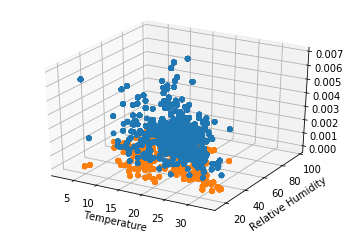

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


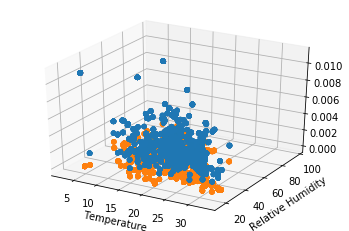

Number of samples to ignore: 5000
Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


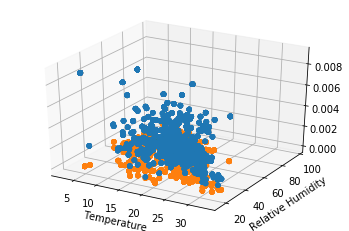

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


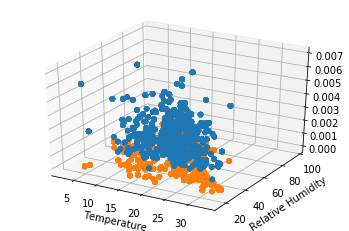

Number of samples to ignore: 10000
Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


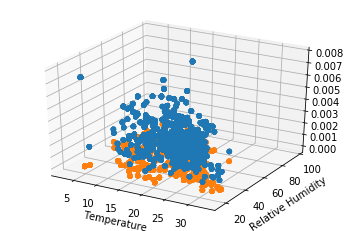

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


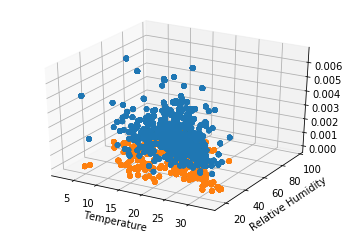

Temperature vs. Wind
Number of samples to ignore: 1000
Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


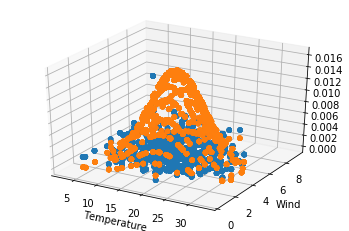

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


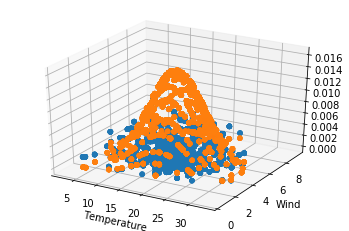

Number of samples to ignore: 5000
Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


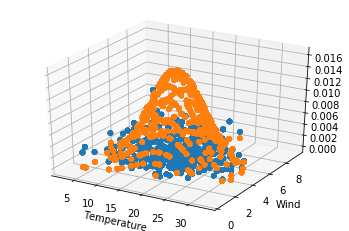

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


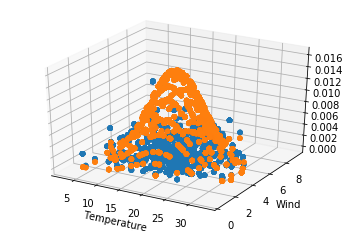

Number of samples to ignore: 10000
Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


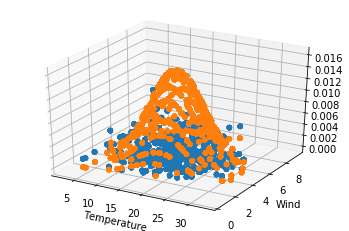

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


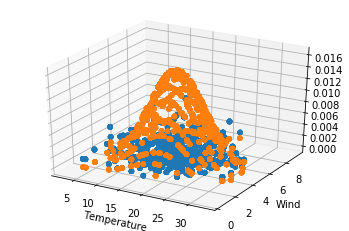

Temperature vs. Rain
Number of samples to ignore: 1000
Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters


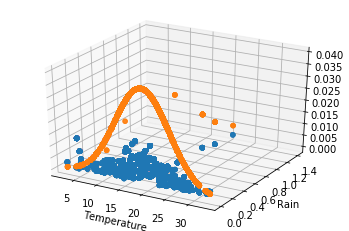

Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters


In [ ]:
features = ["Temperature", "Relative Humidity", "Wind", "Rain"] 

for i in range(0, 4):
    for j in range(0, 4):
        if i > j or i == j:
                continue
        print(features[i] + " vs. " + features[j])
        
        for B in [1000, 5000, 10000]:
            print("Number of samples to ignore: " + str(B))
            feature1 = forest_fires[:, i]
            feature2 = forest_fires[:, j]
            joint_cols = np.zeros((forest_fires.shape[0], 2))
            joint_cols[:, 0] = feature1
            joint_cols[:, 1] = feature2
            sample_pairs, samplesX, samplesY = gibbs_sampler(
                joint_cols, list(feature1), list(feature2), 9000 + B, B)

            mean = MLE_mean(samplesX, samplesY)
            
            covariance = MLE_covariance(samplesX, samplesY, mean)
            
            print("Distribution of Samples Used for Parameter Estimation vs Distribution Obtained w/ Estimated Parameters")
            pdf = gaussian_pdf(samplesX, samplesY, mean, covariance)
            plot_samples_compare(samplesX, samplesY, pdf, sample_pairs, features[i], features[j])
            print("Distribution of New Samples vs Distribution Obtained w/ Estimated Parameters")
            test_pairs, testX, testY = gibbs_sampler(joint_cols, list(feature1), list(feature2), 9000 + B, B)
            testPdf = gaussian_pdf(testX, testY, mean, covariance)
            plot_samples_compare(testX, testY, testPdf, test_pairs, features[i], features[j])
        
            